# Trabalho Prático - Aprendizado Descritivo
Tema: Detecção de Discurso de Ódio nas Redes Sociais: Uma Abordagem de Extração de Padrões com Algoritmo Apriori

Discentes: Gabriel Ikaro Fonseca Paiva, Hugo Bakary, João Vítor Vaz, Victor Hugo Martins, Vitória Maria Silva Bispo.

Docente: Renato Vimieiro



## Configuração do Ambiente

### Pacotes

In [ ]:
!pip install ftfy
!pip install nltk
!pip install apyori

## Bibliotecas ##


In [ ]:
import nltk
import csv
import re
import ftfy
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import pandas as pd
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori as mlx_apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import warnings

# Ignorar DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # ignorar aviso de "should_run_async"

## Limpeza de Dados

###Download StopWords##

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('rslp')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

###Limpeza de Dados Textuais##


In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1vWH6O5bXGyL1Q9UBHUeLSpYJ6fddMn6eA8O6i0sgjvM/export?format=csv' #DISCURSO DE ODIO

# Ler o arquivo CSV diretamente do link
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data, encoding="utf-8")

# Função para limpar os dados
def limpar_dados(texto):
    texto = str(texto)
    texto = ftfy.fix_text(texto)  # Corrige erros de codificação de texto
    texto = texto.split("#")[0]
    texto = texto.split("https://")[0]
    texto = re.sub(r'k{2,}', '', texto) # Remover a sequência  de k's
    texto = re.sub(r'\d+', '', texto)  # Remove números
    texto = re.sub(r'@\w+\s?', '', str(texto))  # Remove o padrão "@algumusuario"
    texto = re.sub(r'\bRT\b', '', texto, flags=re.IGNORECASE)  # Remove a sequência "RT"
    texto = re.sub(r'\s?:\s?', ' ', texto)  # Remove o símbolo " : "
    texto = re.sub(r'https://\S+', '', texto)  # Remove trechos que começam com "https://" seguidos por qualquer sequência de caracteres não espaços em branco
    texto = re.sub(r'http://\S+', '', texto)  # Remove trechos que começam com "http://" seguidos por qualquer sequência de caracteres não espaços em branco
    texto = re.sub(r'[^\w\s]|_+', '', texto)  # Remove emojis
    texto = re.sub(r'"', '', texto)  # Remove aspas
    texto = re.sub(r'[^\w\s]', '', texto)  # Remove pontuação
    texto = re.sub(r'mention', '', texto) # Remover a palavra "mention"
    texto = re.sub(r'馃', 'c', texto) # Decodificar o caractere 'ç'
    texto = re.sub(r'[^a-zA-Z\s]', '', texto) # Manter apenas palavras no nosso alfabeto

    return texto

df['text'] = df['text'].apply(limpar_dados)

df.to_csv('dadosLimpos.csv', index=False, encoding='utf-8')

###Transformação de tweets em minúsculos##


In [ ]:
df = pd.read_csv('dadosLimpos.csv', encoding='utf-8')

def preprocess_lower(text):
    if isinstance(text, str):
        tokens = nltk.word_tokenize(text.lower(), language='portuguese')
        return ' '.join(tokens)
    else:
        return text

df['text'] = df['text'].apply(preprocess_lower)

df.to_csv('dadosMinusculos.csv', index=False, encoding='utf-8')


###Remoção de StopWords##


In [ ]:
df = pd.read_csv('dadosMinusculos.csv', encoding='utf-8')

stop_words = set(stopwords.words('portuguese'))

def remove_stopwords(text):
    if isinstance(text, str):
        filtered_text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
        return filtered_text
    else:
        return text

df['text'] = df['text'].apply(remove_stopwords)
df.to_csv('dadosSemStopWords.csv', index=False, encoding='utf-8')


###Remoção de linhas em branco##


In [ ]:
df = pd.read_csv('dadosSemStopWords.csv', encoding='utf-8')

df.dropna(subset=['text'], inplace=True)
df = df[df['text'].str.strip() != '']

df.to_csv('dadosFinal.csv', index=False, encoding='utf-8')

## Vetorização

### Divisão entre dados ofensivos e complemento

In [ ]:

# Criar o vetor de palavras (TfidfVectorizer)
K = 15

def subtracao(df_ofensivo, df_complemento):
  vectorizer = TfidfVectorizer()
  vectorizer.fit(df_cleaned['text'])

  ### Cálculo de frequências de palavras
  # Vetorizar os textos ofensivos e do complemento
  vectorized_ofensivo = vectorizer.transform(df_ofensivo['text'])
  vectorized_complemento = vectorizer.transform(df_complemento['text'])

  # Obter o vocabulário (palavras únicas)
  vocabulario = vectorizer.get_feature_names_out()

  # Obter a frequência de cada palavra em cada conjunto
  frequencias_ofensivo = vectorized_ofensivo.toarray().sum(axis=0)
  frequencias_complemento = vectorized_complemento.toarray().sum(axis=0)

  # Normalizar as frequências entre 0 e 1
  frequencias_ofensivo_normalizadas = frequencias_ofensivo / frequencias_ofensivo.max()
  frequencias_complemento_normalizadas = frequencias_complemento / frequencias_complemento.max()

  # Criar DataFrames para exibir as frequências
  df_frequencias_ofensivo = pd.DataFrame(frequencias_ofensivo_normalizadas, index=vocabulario, columns=['Frequência Ofensivo']).sort_values(by='Frequência Ofensivo', ascending=False)
  df_frequencias_complemento = pd.DataFrame(frequencias_complemento_normalizadas, index=vocabulario, columns=['Frequência do Complemento']).sort_values(by='Frequência do Complemento', ascending=False)

  # Identificar as 20 palavras mais frequentes nos dados do complemento
  top_K_palavras_complemento = df_frequencias_complemento.head(K).index

  # Remover essas palavras das frequências ofensivas
  df_frequencias_ofensivo_filtrado = df_frequencias_ofensivo.drop(index=top_K_palavras_complemento, errors='ignore')
  df_frequencias_ofensivo_filtrado = df_frequencias_ofensivo_filtrado[df_frequencias_ofensivo_filtrado['Frequência Ofensivo'] > 0]

  # Exibir as frequências
  print("Frequências Ofensivas:")
  print(df_frequencias_ofensivo)

  print("\nFrequências do Complemento:")
  print(df_frequencias_complemento)

  print("\nFrequências Ofensivas (após remover as K palavras mais frequentes dos dados do complemento):")
  print(df_frequencias_ofensivo_filtrado)

  return df_ofensivo, df_frequencias_ofensivo_filtrado

def subtracao_de_subsets(df_cleaned, categorias_a_manter):
  # Definição dos subsets de colunas
  category_subsets = categorias_a_manter

  # Filtra os dados ofensivos
  df_ofensivo = df_cleaned[(df_cleaned[category_subsets] == 1).any(axis=1)]

  # Filtra os dados do complemento
  df_complemento = df_cleaned[~(df_cleaned[category_subsets] == 1).any(axis=1)]

  return subtracao(df_ofensivo, df_complemento)

### Funções Auxiliares

In [ ]:
# Geração de dataset apenas com termos ofensivos
def filtrar_texto(texto, palavras_ofensivas):
  palavras_ofensivas = palavras_ofensivas.index.tolist()
  palavras_filtradas = [palavra for palavra in texto.split() if palavra in palavras_ofensivas]
  return ' '.join(palavras_filtradas)

def manter_apenas_palavras_ofensivas(df_ofensivo, palavras_ofensivas):
  df_ofensivo['text'] = df_ofensivo['text'].apply(lambda texto: filtrar_texto(texto, palavras_ofensivas))

## Extração de Itemsets

### Aplicação do Apriori sobre Categorias de Ódio

In [ ]:
def preparar_categoria_de_odio_para_apriori(df_cleaned, subconjuntos_ofensivos):

  df_CategoriaDeOdio, df_frequencias_CategoriaDeOdio_filtrado = subtracao_de_subsets(df_cleaned,subconjuntos_ofensivos)

  manter_apenas_palavras_ofensivas(df_CategoriaDeOdio, df_frequencias_CategoriaDeOdio_filtrado)
  return df_CategoriaDeOdio

In [ ]:
# Carregar o DataFrame
df_cleaned = pd.read_csv('dadosFinal.csv', encoding='utf-8')
subconjuntos_ofensivos = ['homophobia_1', 'homophobia_2', 'homophobia_3']
df_Homofobico = preparar_categoria_de_odio_para_apriori(df_cleaned, subconjuntos_ofensivos)

Frequências Ofensivas:
           Frequência Ofensivo
viado                 1.000000
boiola                0.360987
sapato                0.325191
bicha                 0.279745
gay                   0.259111
...                        ...
entendido             0.000000
entendida             0.000000
entendia              0.000000
entendi               0.000000
zzz                   0.000000

[24516 rows x 1 columns]

Frequências do Complemento:
           Frequência do Complemento
porra                       1.000000
pqp                         0.924700
pra                         0.905137
caralho                     0.893570
vai                         0.648235
...                              ...
recalcada                   0.000000
alisson                     0.000000
luko                        0.000000
ryujin                      0.000000
viadoooo                    0.000000

[24516 rows x 1 columns]

Frequências Ofensivas (após remover as K palavras mais frequentes dos dados do 

<ipython-input-136-802191d29f68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ofensivo['text'] = df_ofensivo['text'].apply(lambda texto: filtrar_texto(texto, palavras_ofensivas))


In [ ]:
def aplicar_apriori(df, classe):
    # Crie a lista de transações dividindo os comentários em palavras
    transactions = df['text'].str.split().tolist()

    # Transforme as transações em um formato adequado para mlxtend
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Aplique o algoritmo Apriori
    frequent_itemsets = mlx_apriori(df_encoded, min_support=0.01, use_colnames=True)

    # Gere as regras de associação
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
    rules = rules[rules['lift'] >= 2]

    # Imprimir conjuntos frequentes
    print("Conjuntos de dados frequentes:")
    print(frequent_itemsets)

    # Retorne os conjuntos frequentes e transações codificadas
    df_itemsets = frequent_itemsets[['itemsets', 'support']]
    df_itemsets['itemsets'] = df_itemsets['itemsets'].apply(list)

    df_transactions = pd.DataFrame()
    df_transactions[classe] = pd.Series(transactions)

    return df_itemsets, df_transactions

In [ ]:
itemsets_homofobia, trans_homofobia = aplicar_apriori(df_Homofobico, 'homofobia')

Conjuntos de dados frequentes:
      support       itemsets
0    0.023256        (agora)
1    0.011628      (aguenta)
2    0.020349           (ai)
3    0.026163        (ainda)
4    0.014535        (amiga)
..        ...            ...
109  0.011628  (mundo, todo)
110  0.011628    (ver, pode)
111  0.011628  (viado, pode)
112  0.017442    (viado, pq)
113  0.017442  (viado, quer)

[114 rows x 2 columns]


In [ ]:
# Carregar o DataFrame
df_cleaned = pd.read_csv('dadosFinal.csv', encoding='utf-8')
subconjuntos_ofensivos = ['obscene_1', 'obscene_2', 'obscene_3']
df_Obscene = preparar_categoria_de_odio_para_apriori(df_cleaned, subconjuntos_ofensivos)

Frequências Ofensivas:
                 Frequência Ofensivo
porra                       1.000000
cu                          0.980078
caralho                     0.915507
pqp                         0.733307
puta                        0.618040
...                              ...
fundamental                 0.000000
fundamentalista             0.000000
fundamento                  0.000000
fundao                      0.000000
zzz                         0.000000

[24516 rows x 1 columns]

Frequências do Complemento:
             Frequência do Complemento
pra                           1.000000
pqp                           0.824102
porra                         0.677805
to                            0.600211
caralho                       0.597096
...                                ...
descendncia                   0.000000
prox                          0.000000
provocou                      0.000000
provocao                      0.000000
desastre                      0.000000

[24516 ro

<ipython-input-136-802191d29f68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ofensivo['text'] = df_ofensivo['text'].apply(lambda texto: filtrar_texto(texto, palavras_ofensivas))


In [ ]:
itemsets_obsceno, trans_obsceno = aplicar_apriori(df_Obscene, 'obsceno')

Conjuntos de dados frequentes:
     support     itemsets
0   0.010415       (acho)
1   0.023396      (agora)
2   0.021736         (ai)
3   0.025057      (ainda)
4   0.013736      (algum)
..       ...          ...
90  0.014038    (vontade)
91  0.018868        (vsf)
92  0.012377    (pau, cu)
93  0.019472   (toma, cu)
94  0.037585  (tomar, cu)

[95 rows x 2 columns]


In [ ]:
# Carregar o DataFrame
df_cleaned = pd.read_csv('dadosFinal.csv', encoding='utf-8')
subconjuntos_ofensivos = ['insult_1', 'insult_2', 'insult_3']
df_Insult = preparar_categoria_de_odio_para_apriori(df_cleaned, subconjuntos_ofensivos)

Frequências Ofensivas:
            Frequência Ofensivo
cu                     1.000000
vai                    0.943360
puta                   0.748969
pra                    0.673280
cara                   0.585324
...                         ...
fracassar              0.000000
fracassada             0.000000
fracassa               0.000000
fracas                 0.000000
inscritos              0.000000

[24516 rows x 1 columns]

Frequências do Complemento:
          Frequência do Complemento
porra                      1.000000
pqp                        0.973973
caralho                    0.864055
pra                        0.845102
to                         0.534608
...                             ...
grp                        0.000000
ses                        0.000000
gritarem                   0.000000
gritaram                   0.000000
zzz                        0.000000

[24516 rows x 1 columns]

Frequências Ofensivas (após remover as K palavras mais frequentes dos dados do 

<ipython-input-136-802191d29f68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ofensivo['text'] = df_ofensivo['text'].apply(lambda texto: filtrar_texto(texto, palavras_ofensivas))


In [ ]:
itemsets_insulto, trans_insulto = aplicar_apriori(df_Insult, 'insulto')

Conjuntos de dados frequentes:
      support     itemsets
0    0.011692       (acha)
1    0.013067       (acho)
2    0.021550      (agora)
3    0.011004         (ah)
4    0.020862         (ai)
..        ...          ...
107  0.016048         (vo)
108  0.034846        (voc)
109  0.013297       (vocs)
110  0.016277        (vsf)
111  0.012380  (cara, pau)

[112 rows x 2 columns]


In [ ]:
# Carregar o DataFrame
df_cleaned = pd.read_csv('dadosFinal.csv', encoding='utf-8')
subconjuntos_ofensivos = ['racism_1', 'racism_2', 'racism_3']
df_Racism = preparar_categoria_de_odio_para_apriori(df_cleaned, subconjuntos_ofensivos)

Frequências Ofensivas:
          Frequência Ofensivo
nego                 1.000000
branco               0.577840
macaca               0.460946
pretinho             0.420199
pretinha             0.396627
...                       ...
engolem              0.000000
engole               0.000000
english              0.000000
engineer             0.000000
zzz                  0.000000

[24516 rows x 1 columns]

Frequências do Complemento:
              Frequência do Complemento
porra                          1.000000
pqp                            0.924418
pra                            0.916058
caralho                        0.901451
vai                            0.651656
...                                 ...
barrigudos                     0.000000
facilidades                    0.000000
negoo                          0.000000
pitel                          0.000000
toxoplasmose                   0.000000

[24516 rows x 1 columns]

Frequências Ofensivas (após remover as K palavras mais 

<ipython-input-136-802191d29f68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ofensivo['text'] = df_ofensivo['text'].apply(lambda texto: filtrar_texto(texto, palavras_ofensivas))


In [ ]:
itemsets_racismo, trans_racismo = aplicar_apriori(df_Racism, 'racismo')

Conjuntos de dados frequentes:
      support                                           itemsets
0    0.014493                                            (abrao)
1    0.021739                                             (acho)
2    0.043478                                            (agora)
3    0.014493                                    (agressividade)
4    0.036232                                               (ai)
..        ...                                                ...
351  0.014493  (competente, cor, honesto, prefeito, president...
352  0.014493  (competente, cor, prefeito, presidente, idiota...
353  0.014493  (competente, honesto, prefeito, presidente, id...
354  0.014493  (cor, honesto, prefeito, presidente, idiota, o...
355  0.014493  (competente, cor, honesto, prefeito, president...

[356 rows x 2 columns]


In [ ]:
# Carregar o DataFrame
df_cleaned = pd.read_csv('dadosFinal.csv', encoding='utf-8')
subconjuntos_ofensivos = ['misogyny_1', 'misogyny_2', 'misogyny_3']
df_misogyny = preparar_categoria_de_odio_para_apriori(df_cleaned, subconjuntos_ofensivos)

Frequências Ofensivas:
           Frequência Ofensivo
putinha               1.000000
piranha               0.882065
puta                  0.580789
vagabunda             0.520978
mulher                0.367432
...                        ...
enxurrada             0.000000
enxergue              0.000000
enxergo               0.000000
enxergava             0.000000
zzz                   0.000000

[24516 rows x 1 columns]

Frequências do Complemento:
           Frequência do Complemento
porra                       1.000000
pqp                         0.925788
pra                         0.904843
caralho                     0.896410
cu                          0.645005
...                              ...
vaginilda                   0.000000
mnet                        0.000000
icones                      0.000000
otarias                     0.000000
permito                     0.000000

[24516 rows x 1 columns]

Frequências Ofensivas (após remover as K palavras mais frequentes dos dados do 

<ipython-input-136-802191d29f68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ofensivo['text'] = df_ofensivo['text'].apply(lambda texto: filtrar_texto(texto, palavras_ofensivas))


In [ ]:
itemsets_misoginia, trans_misoginia = aplicar_apriori(df_misogyny, 'misoginia')

Conjuntos de dados frequentes:
      support          itemsets
0    0.015217            (acha)
1    0.013043         (achando)
2    0.013043            (acho)
3    0.015217           (agora)
4    0.013043         (aguenta)
..        ...               ...
124  0.013043             (vsf)
125  0.010870   (mulher, homem)
126  0.010870  (piranha, homem)
127  0.013043    (mulher, quer)
128  0.010870    (mulher, tudo)

[129 rows x 2 columns]


In [ ]:
# Carregar o DataFrame
df_cleaned = pd.read_csv('dadosFinal.csv', encoding='utf-8')
subconjuntos_ofensivos = ['xenophobia_1', 'xenophobia_2', 'xenophobia_3']
df_xenophobia = preparar_categoria_de_odio_para_apriori(df_cleaned, subconjuntos_ofensivos)

Frequências Ofensivas:
            Frequência Ofensivo
sulista                1.000000
carioca                0.632856
paulista               0.308247
pra                    0.267208
nordestino             0.245178
...                         ...
enigma                 0.000000
engrenagem             0.000000
engravidou             0.000000
engravidem             0.000000
zzz                    0.000000

[24516 rows x 1 columns]

Frequências do Complemento:
             Frequência do Complemento
porra                         1.000000
pqp                           0.925105
pra                           0.915006
caralho                       0.903475
vai                           0.653647
...                                ...
comunas                       0.000000
comunho                       0.000000
aires                         0.000000
perfomances                   0.000000
acertada                      0.000000

[24516 rows x 1 columns]

Frequências Ofensivas (após remover as K pa

<ipython-input-136-802191d29f68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ofensivo['text'] = df_ofensivo['text'].apply(lambda texto: filtrar_texto(texto, palavras_ofensivas))


In [ ]:
itemsets_xenofobia, trans_xenofobia= aplicar_apriori(df_xenophobia, 'xenofobia')

Conjuntos de dados frequentes:
      support                            itemsets
0    0.013245                           (aberrao)
1    0.013245                             (abrao)
2    0.013245                              (acha)
3    0.013245                             (achar)
4    0.013245                         (acontecer)
..        ...                                 ...
280  0.013245                 (brasil, bem, aqui)
281  0.013245                     (vez, cada, ta)
282  0.013245                (odiar, sulista, eh)
283  0.013245      (povo, nordestino, presidente)
284  0.013245  (povo, nordestino, presidente, ah)

[285 rows x 2 columns]


## Testes

## Utilizando 6 classes

In [ ]:
#Pegando apenas o texto de cada dataset
df_Obscene = df_Obscene[['text']]
df_Insult = df_Insult[['text']]
df_Racism = df_Racism[['text']]
df_misogyny = df_misogyny[['text']]
df_xenophobia = df_xenophobia[['text']]
df_Homofobico = df_Homofobico[['text']]

#Adicionando as classes
df_Obscene['classe'] = 'obsceno'
df_Insult['classe'] = 'insulto'
df_Racism['classe'] = 'racismo'
df_misogyny['classe'] = 'misoginia'
df_xenophobia['classe'] = 'xenofobia'
df_Homofobico['classe'] = 'homofobia'

#Unificando em um só
df_total = pd.concat([df_Racism, df_misogyny, df_xenophobia, df_Homofobico, df_Obscene, df_Insult], axis=0)
df_total = df_total.drop_duplicates(subset='text')
df_total

<ipython-input-151-1fefc3e87cd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Obscene['classe'] = 'obsceno'
<ipython-input-151-1fefc3e87cd6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Insult['classe'] = 'insulto'
<ipython-input-151-1fefc3e87cd6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,text,classe
54,desgoverno destruio esconde dados sendo engana...,racismo
60,segue pgina shitpost humor negroshitpost ento ...,racismo
166,fala barro preto,racismo
292,duvivier ningum conhece trouxa ptralha parabas...,racismo
523,nordestino todo nordestino igual,racismo
...,...,...
20819,vergonha todo lado amigo imprensa ridcula bast...,insulto
20842,desgraa vier falar cmg novo mando tomar,insulto
20845,reclamam boca suja desculpa tomar,insulto
20850,espao vrgula burro,insulto


In [ ]:
#Lista de itemsets de cada categoria
itemsets_list = [itemsets_xenofobia, itemsets_homofobia, itemsets_racismo, itemsets_misoginia, itemsets_insulto, itemsets_obsceno]

df_itemsets = pd.DataFrame()

#Faz a união em um dataframe só
for df in itemsets_list:
  df = df.drop('support', axis=1)
  df_itemsets = pd.concat([df_itemsets, df], ignore_index=True)

#df_itemsets = df_itemsets.drop_duplicates(subset='itemsets')
df_itemsets

,itemsets
0,[aberrao]
1,[abrao]
2,[acha]
3,[achar]
4,[acontecer]
...,...
1086,[vontade]
1087,[vsf]
1088,"[pau, cu]"
1089,"[toma, cu]"


In [ ]:
#Remove duplicadas
df_itemsets = df_itemsets.drop_duplicates(subset='itemsets')

df_itemsets

,itemsets
0,[aberrao]
1,[abrao]
2,[acha]
3,[achar]
4,[acontecer]
...,...
1037,[jogo]
1038,[linda]
1088,"[pau, cu]"
1089,"[toma, cu]"


### Regressão Logística

In [ ]:
# Exemplo de listas de palavras (itemsets) e frases
itemsets = df_itemsets['itemsets'].tolist()
frases = df_total['text'].tolist()
# Exemplo de rótulos para as frases
rotulos = df_total['classe'].tolist()

# Função para verificar se todos os itens de um itemset estão presentes na frase
def verifica_presenca(itemset, frase):
    return all(palavra in frase for palavra in itemset)

# Criar um dicionário para armazenar os resultados
resultados = {'frase': frases}

# Para cada itemset, verificar a presença em cada frase
for i, itemset in enumerate(itemsets):
    resultados[f'itemset_{i+1}'] = [verifica_presenca(itemset, frase) for frase in frases]

# Adicionar a coluna de rótulos ao dicionário
resultados['rotulo'] = rotulos

# Criar o DataFrame
df = pd.DataFrame(resultados)

# Converter valores booleanos para inteiros (0 e 1)
for col in df.columns[1:-1]:  # Ignorar a coluna de frases e a coluna de rótulos
    df[col] = df[col].astype(int)

# Exibir o DataFrame
print("DataFrame:\n", df)

# Separar os dados e os rótulos
X = df.drop(columns=['frase', 'rotulo'])
y = df['rotulo']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

DataFrame:
                                                   frase  itemset_1  itemset_2  \
0     desgoverno destruio esconde dados sendo engana...          0          0   
1     segue pgina shitpost humor negroshitpost ento ...          0          0   
2                                      fala barro preto          0          0   
3     duvivier ningum conhece trouxa ptralha parabas...          0          0   
4                      nordestino todo nordestino igual          0          0   
...                                                 ...        ...        ...   
9499  vergonha todo lado amigo imprensa ridcula bast...          0          0   
9500            desgraa vier falar cmg novo mando tomar          0          0   
9501                  reclamam boca suja desculpa tomar          0          0   
9502                                 espao vrgula burro          0          0   
9503                                   pai irresponsvel          0          0   

      itemset_3

In [ ]:
# Treinar o modelo de regressão logística
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Avaliar a acurácia do modelo
acuracia = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acuracia}')

# Relatório de classificação detalhado
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.7532877432930036
Relatório de classificação:
               precision    recall  f1-score   support

   homofobia       0.79      0.64      0.71        59
     insulto       0.66      0.53      0.59       489
   misoginia       0.65      0.29      0.40        82
     obsceno       0.78      0.91      0.84      1207
     racismo       0.86      0.16      0.27        38
   xenofobia       0.64      0.27      0.38        26

    accuracy                           0.75      1901
   macro avg       0.73      0.47      0.53      1901
weighted avg       0.74      0.75      0.73      1901



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
relatorio_classificacao = classification_report(y_test, y_pred, output_dict=True)

# Imprimir a acurácia para cada classe
print("Métricas individuais por classe:")
for classe, metrics in relatorio_classificacao.items():
    if classe != 'accuracy':  # 'accuracy' é a acurácia global, não por classe
        print(f"Classe {classe}:")
        print(f"  Precisão: {metrics['precision']}")
        print(f"  Recall: {metrics['recall']}")
        print(f"  F1-Score: {metrics['f1-score']}")
        print(f"  Quantidade de Exemplos: {metrics['support']}")

Métricas individuais por classe:
Classe homofobia:
  Precisão: 0.7916666666666666
  Recall: 0.6440677966101694
  F1-Score: 0.7102803738317757
  Quantidade de Exemplos: 59.0
Classe insulto:
  Precisão: 0.6598984771573604
  Recall: 0.5316973415132924
  F1-Score: 0.5889014722536806
  Quantidade de Exemplos: 489.0
Classe misoginia:
  Precisão: 0.6486486486486487
  Recall: 0.2926829268292683
  F1-Score: 0.4033613445378151
  Quantidade de Exemplos: 82.0
Classe obsceno:
  Precisão: 0.7813390313390314
  Recall: 0.9088649544324772
  F1-Score: 0.8402910762160092
  Quantidade de Exemplos: 1207.0
Classe racismo:
  Precisão: 0.8571428571428571
  Recall: 0.15789473684210525
  F1-Score: 0.26666666666666666
  Quantidade de Exemplos: 38.0
Classe xenofobia:
  Precisão: 0.6363636363636364
  Recall: 0.2692307692307692
  F1-Score: 0.37837837837837834
  Quantidade de Exemplos: 26.0
Classe macro avg:
  Precisão: 0.7291765528863667
  Recall: 0.46740642090968026
  F1-Score: 0.5313132186473876
  Quantidade de E

Matriz de Confusão:
            homofobia  misoginia  xenofobia  racismo  obsceno  insulto
homofobia         38          0          0        0       15        6
misoginia          4         24          1        0       42       11
xenofobia          0          1          7        0       11        7
racismo            0          0          1        6       22        9
obsceno            4          3          2        0     1097      101
insulto            2          9          0        1      217      260


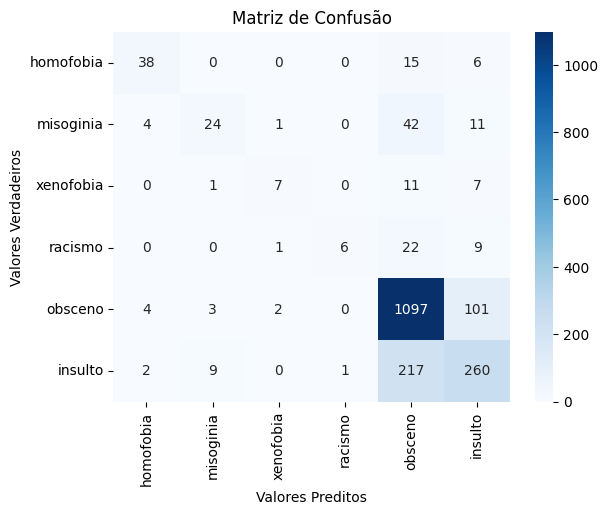

In [ ]:
# Exemplo de listas de valores verdadeiros e predições
valores_verdadeiros = y_test.values
predicoes = y_pred

# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(valores_verdadeiros, predicoes, labels=['homofobia', 'misoginia', 'xenofobia', 'racismo', 'obsceno', 'insulto'])

# Converter a matriz de confusão para um DataFrame para visualização
df_matriz_confusao = pd.DataFrame(matriz_confusao, index=['homofobia', 'misoginia', 'xenofobia', 'racismo', 'obsceno', 'insulto'], columns=['homofobia', 'misoginia', 'xenofobia', 'racismo', 'obsceno', 'insulto'])

# Exibir a matriz de confusão
print("Matriz de Confusão:\n", df_matriz_confusao)

# Visualizar a matriz de confusão usando seaborn
sns.heatmap(df_matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

### Naive Bayes

In [ ]:
modelo = MultinomialNB(alpha=0.25)
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Obter o relatório de classificação
relatorio_classificacao = classification_report(y_test, y_pred, output_dict=True)

print("Relatório de classificação:\n", classification_report(y_test, y_pred))

# Imprimir a acurácia para cada classe
print("Métricas individuais por classe:")
for classe, metrics in relatorio_classificacao.items():
    if classe != 'accuracy':  # 'accuracy' é a acurácia global, não por classe
        print(f"Classe {classe}:")
        print(f"  Precisão: {metrics['precision']}")
        print(f"  Recall: {metrics['recall']}")
        print(f"  F1-Score: {metrics['f1-score']}")
        print(f"  Quantidade de Exemplos: {metrics['support']}")

Relatório de classificação:
               precision    recall  f1-score   support

   homofobia       0.75      0.68      0.71        59
     insulto       0.59      0.49      0.53       489
   misoginia       0.45      0.30      0.36        82
     obsceno       0.78      0.87      0.82      1207
     racismo       0.60      0.24      0.34        38
   xenofobia       0.67      0.38      0.49        26

    accuracy                           0.72      1901
   macro avg       0.64      0.49      0.54      1901
weighted avg       0.71      0.72      0.71      1901

Métricas individuais por classe:
Classe homofobia:
  Precisão: 0.7547169811320755
  Recall: 0.6779661016949152
  F1-Score: 0.7142857142857143
  Quantidade de Exemplos: 59.0
Classe insulto:
  Precisão: 0.5891089108910891
  Recall: 0.4867075664621677
  F1-Score: 0.5330347144456886
  Quantidade de Exemplos: 489.0
Classe misoginia:
  Precisão: 0.45454545454545453
  Recall: 0.3048780487804878
  F1-Score: 0.36496350364963503
  Qua

Matriz de Confusão:
            homofobia  misoginia  xenofobia  racismo  obsceno  insulto
homofobia         40          1          0        0       12        6
misoginia          4         25          1        0       39       13
xenofobia          2          4         10        0        5        5
racismo            0          1          0        9       19        9
obsceno            4          9          3        2     1056      133
insulto            3         15          1        4      228      238


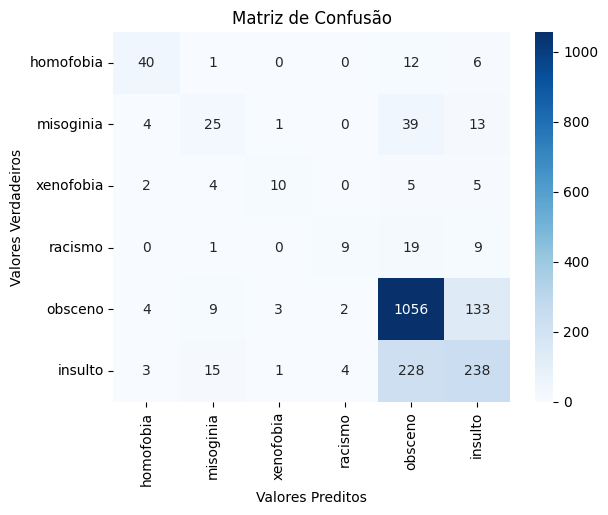

In [ ]:
# Exemplo de listas de valores verdadeiros e predições
valores_verdadeiros = y_test.values
predicoes = y_pred

# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(valores_verdadeiros, predicoes, labels=['homofobia', 'misoginia', 'xenofobia', 'racismo', 'obsceno', 'insulto'])

# Converter a matriz de confusão para um DataFrame para visualização
df_matriz_confusao = pd.DataFrame(matriz_confusao, index=['homofobia', 'misoginia', 'xenofobia', 'racismo', 'obsceno', 'insulto'], columns=['homofobia', 'misoginia', 'xenofobia', 'racismo', 'obsceno', 'insulto'])

# Exibir a matriz de confusão
print("Matriz de Confusão:\n", df_matriz_confusao)

# Visualizar a matriz de confusão usando seaborn
sns.heatmap(df_matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

## Sem obsceno e insulto
Com apenas 4 classes

In [ ]:
df_total = pd.concat([df_Racism, df_misogyny, df_xenophobia, df_Homofobico], axis=0)

#Remove duplicadas
df_total = df_total.drop_duplicates(subset='text')

df_total

,text,classe
54,desgoverno destruio esconde dados sendo engana...,racismo
60,segue pgina shitpost humor negroshitpost ento ...,racismo
166,fala barro preto,racismo
292,duvivier ningum conhece trouxa ptralha parabas...,racismo
523,nordestino todo nordestino igual,racismo
...,...,...
20511,siga devolta bixa cabeona,homofobia
20772,susto viado,homofobia
20786,aq querendo sapato,homofobia
20792,pq todo gay lindo retardado,homofobia


### Regressão Logística

In [ ]:
# Exemplo de listas de palavras (itemsets) e frases
itemsets = df_itemsets['itemsets'].tolist()
frases = df_total['text'].tolist()
# Exemplo de rótulos para as frases
rotulos = df_total['classe'].tolist()

# Função para verificar se todos os itens de um itemset estão presentes na frase
def verifica_presenca(itemset, frase):
    return all(palavra in frase for palavra in itemset)

# Criar um dicionário para armazenar os resultados
resultados = {'frase': frases}

# Para cada itemset, verificar a presença em cada frase
for i, itemset in enumerate(itemsets):
    resultados[f'itemset_{i+1}'] = [verifica_presenca(itemset, frase) for frase in frases]

# Adicionar a coluna de rótulos ao dicionário
resultados['rotulo'] = rotulos

# Criar o DataFrame
df = pd.DataFrame(resultados)

# Converter valores booleanos para inteiros (0 e 1)
for col in df.columns[1:-1]:  # Ignorar a coluna de frases e a coluna de rótulos
    df[col] = df[col].astype(int)

# Exibir o DataFrame
print("DataFrame:\n", df)

# Separar os dados e os rótulos
X = df.drop(columns=['frase', 'rotulo'])
y = df['rotulo']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

DataFrame:
                                                   frase  itemset_1  itemset_2  \
0     desgoverno destruio esconde dados sendo engana...          0          0   
1     segue pgina shitpost humor negroshitpost ento ...          0          0   
2                                      fala barro preto          0          0   
3     duvivier ningum conhece trouxa ptralha parabas...          0          0   
4                      nordestino todo nordestino igual          0          0   
...                                                 ...        ...        ...   
997                           siga devolta bixa cabeona          0          0   
998                                         susto viado          0          0   
999                                  aq querendo sapato          0          0   
1000                        pq todo gay lindo retardado          0          0   
1001  queria conhecer algum conhece hetero taubat me...          0          0   

      itemset_3

In [ ]:
# Treinar o modelo de regressão logística
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Avaliar a acurácia do modelo
acuracia = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acuracia}')

# Relatório de classificação detalhado
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.7761194029850746
Relatório de classificação:
               precision    recall  f1-score   support

   homofobia       0.88      0.83      0.85        70
   misoginia       0.74      0.91      0.81        87
     racismo       0.58      0.37      0.45        19
   xenofobia       0.75      0.48      0.59        25

    accuracy                           0.78       201
   macro avg       0.74      0.65      0.68       201
weighted avg       0.77      0.78      0.77       201



In [ ]:
relatorio_classificacao = classification_report(y_test, y_pred, output_dict=True)

# Imprimir a acurácia para cada classe
print("Métricas individuais por classe:")
for classe, metrics in relatorio_classificacao.items():
    if classe != 'accuracy':  # 'accuracy' é a acurácia global, não por classe
        print(f"Classe {classe}:")
        print(f"  Precisão: {metrics['precision']}")
        print(f"  Recall: {metrics['recall']}")
        print(f"  F1-Score: {metrics['f1-score']}")
        print(f"  Quantidade de Exemplos: {metrics['support']}")

Métricas individuais por classe:
Classe homofobia:
  Precisão: 0.8787878787878788
  Recall: 0.8285714285714286
  F1-Score: 0.8529411764705883
  Quantidade de Exemplos: 70.0
Classe misoginia:
  Precisão: 0.7383177570093458
  Recall: 0.9080459770114943
  F1-Score: 0.8144329896907215
  Quantidade de Exemplos: 87.0
Classe racismo:
  Precisão: 0.5833333333333334
  Recall: 0.3684210526315789
  F1-Score: 0.4516129032258065
  Quantidade de Exemplos: 19.0
Classe xenofobia:
  Precisão: 0.75
  Recall: 0.48
  F1-Score: 0.5853658536585366
  Quantidade de Exemplos: 25.0
Classe macro avg:
  Precisão: 0.7376097422826395
  Recall: 0.6462596145536255
  F1-Score: 0.6760882307614132
  Quantidade de Exemplos: 201.0
Classe weighted avg:
  Precisão: 0.77404044630994
  Recall: 0.7761194029850746
  F1-Score: 0.7650564376059089
  Quantidade de Exemplos: 201.0


Matriz de Confusão:
            homofobia  misoginia  xenofobia  racismo
homofobia         58         10          0        2
misoginia          5         79          2        1
xenofobia          2          9         12        2
racismo            1          9          2        7


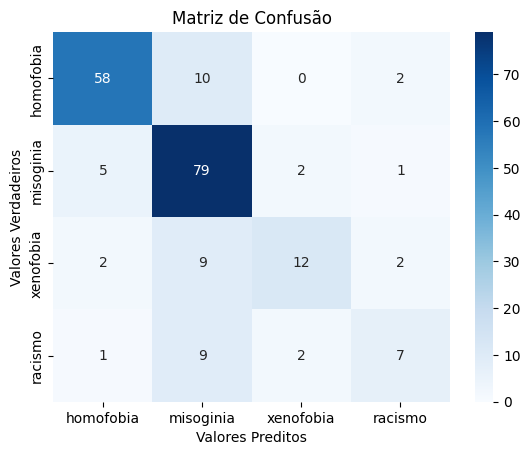

In [ ]:
# Exemplo de listas de valores verdadeiros e predições
valores_verdadeiros = y_test.values
predicoes = y_pred

# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(valores_verdadeiros, predicoes, labels=['homofobia', 'misoginia', 'xenofobia', 'racismo'])

# Converter a matriz de confusão para um DataFrame para visualização
df_matriz_confusao = pd.DataFrame(matriz_confusao, index=['homofobia', 'misoginia', 'xenofobia', 'racismo'], columns=['homofobia', 'misoginia', 'xenofobia', 'racismo'])

# Exibir a matriz de confusão
print("Matriz de Confusão:\n", df_matriz_confusao)

# Visualizar a matriz de confusão usando seaborn
sns.heatmap(df_matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

### Naive Bayes

In [ ]:
modelo = MultinomialNB(alpha=0.25)
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Obter o relatório de classificação
relatorio_classificacao = classification_report(y_test, y_pred, output_dict=True)

print("Relatório de classificação:\n", classification_report(y_test, y_pred))

# Imprimir a acurácia para cada classe
print("Métricas individuais por classe:")
for classe, metrics in relatorio_classificacao.items():
    if classe != 'accuracy':  # 'accuracy' é a acurácia global, não por classe
        print(f"Classe {classe}:")
        print(f"  Precisão: {metrics['precision']}")
        print(f"  Recall: {metrics['recall']}")
        print(f"  F1-Score: {metrics['f1-score']}")
        print(f"  Quantidade de Exemplos: {metrics['support']}")

Relatório de classificação:
               precision    recall  f1-score   support

   homofobia       0.83      0.79      0.81        70
   misoginia       0.73      0.85      0.79        87
     racismo       0.64      0.47      0.55        19
   xenofobia       0.70      0.56      0.62        25

    accuracy                           0.76       201
   macro avg       0.73      0.67      0.69       201
weighted avg       0.76      0.76      0.75       201

Métricas individuais por classe:
Classe homofobia:
  Precisão: 0.8333333333333334
  Recall: 0.7857142857142857
  F1-Score: 0.8088235294117647
  Quantidade de Exemplos: 70.0
Classe misoginia:
  Precisão: 0.7326732673267327
  Recall: 0.8505747126436781
  F1-Score: 0.7872340425531914
  Quantidade de Exemplos: 87.0
Classe racismo:
  Precisão: 0.6428571428571429
  Recall: 0.47368421052631576
  F1-Score: 0.5454545454545454
  Quantidade de Exemplos: 19.0
Classe xenofobia:
  Precisão: 0.7
  Recall: 0.56
  F1-Score: 0.6222222222222222
  Qu

Matriz de Confusão:
            homofobia  misoginia  xenofobia  racismo
homofobia         55         11          1        3
misoginia          9         74          2        2
xenofobia          2          9         14        0
racismo            0          7          3        9


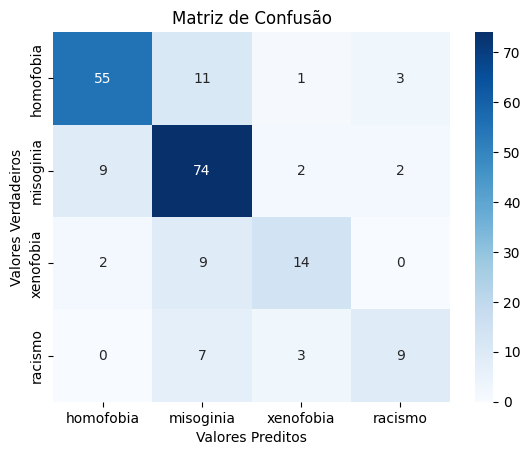

In [ ]:
# Exemplo de listas de valores verdadeiros e predições
valores_verdadeiros = y_test.values
predicoes = y_pred

# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(valores_verdadeiros, predicoes, labels=['homofobia', 'misoginia', 'xenofobia', 'racismo'])

# Converter a matriz de confusão para um DataFrame para visualização
df_matriz_confusao = pd.DataFrame(matriz_confusao, index=['homofobia', 'misoginia', 'xenofobia', 'racismo'], columns=['homofobia', 'misoginia', 'xenofobia', 'racismo'])

# Exibir a matriz de confusão
print("Matriz de Confusão:\n", df_matriz_confusao)

# Visualizar a matriz de confusão usando seaborn
sns.heatmap(df_matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()